# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

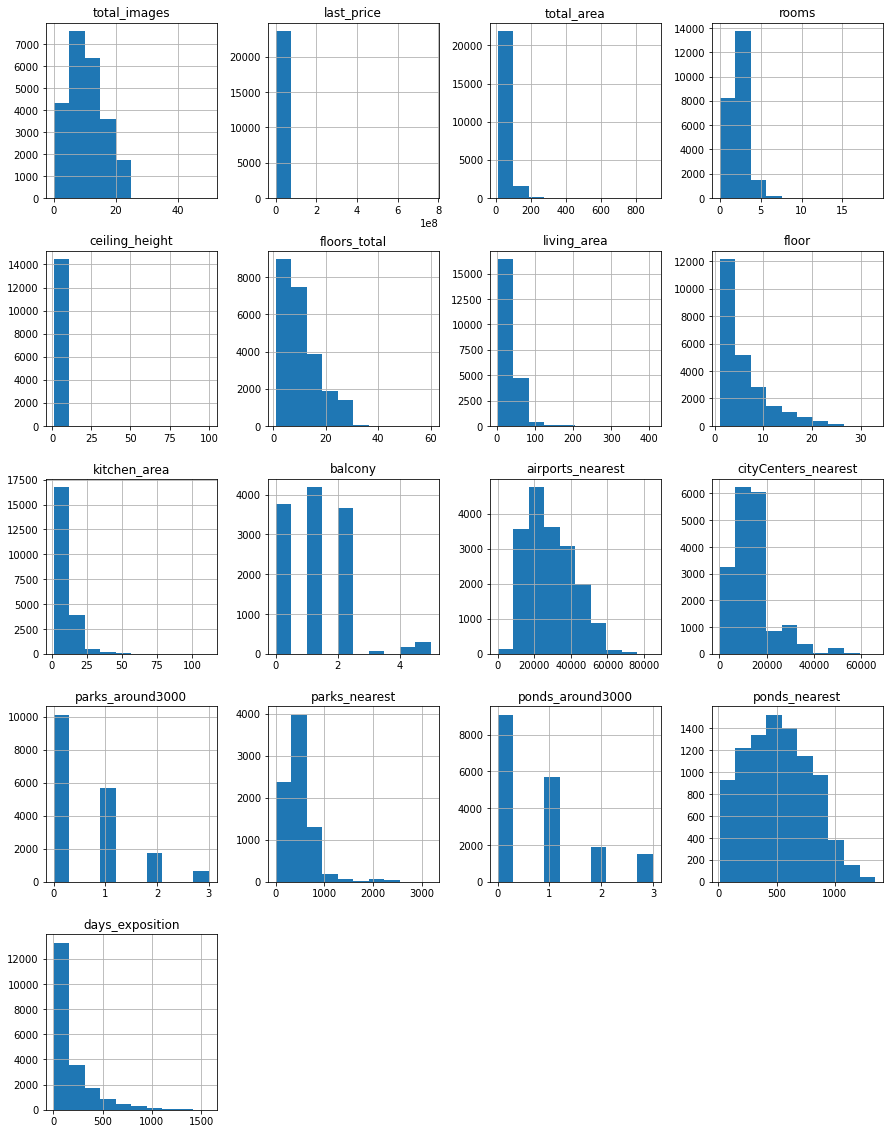

In [1]:
import pandas as pd
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
data.info()
data.hist(figsize=(15, 20));

### Предобработка данных

Изучая данные файла, мы обнаружили:

- что один столбец некорректно назван. Изменим название cityCenters_nearest на city_сenters_nearest.

In [2]:
data.rename(columns={'cityCenters_nearest' : 'city_centers_nearest'}, inplace=True)

- уже явно видны столбцы с пропусками. Посмотрим сколько их и в каких столбцах

In [3]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
city_centers_nearest     5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

Проверить колличество пропусков в % можно вот так: 
    
    
    pd.DataFrame(round(df.isna().mean()*100,)).style.background_gradient('coolwarm')

Всего у нас 23699 строк.

ceiling_height - 9195 - высота потолков. Нет у нас данных для их рассчета или предположения. Оставляем пустым.

floors_total - 86 - всего этажей в доме. Аналогично высоте потолков, оставляем пустым.

living_area - 1903 - жилая площадь в квадратных метрах. Оставляем  пустым.

is_apartment - 20924 - аппартаменты (булев тип). Предположим, что заполнявший данные пропускал этот параметр, тк очевидным было, что это не аппартаменты и можно не проставлять "отметку". Проставим False.

kitchen_area - 2278 - площадь кухни в квадратных метрах. Не предположить обоснованно, не рассчитать, следовательно оставляем  пустым.

balcony - 11519 - число балконов. Аналогично данным из столбца is_apartment, раз не проставленны данные, значит 0 балконов в квартире. Проставим 0. 

locality_name - 49 - название населенного пункта. Оставляем пустым.

airports_nearest - 5542 - расстояние до ближайшего аэропорта в метрах. Нет расстояния, нет аэропорта. Пусто.

city_centers_nearest - 5519 - расстояние до центра города в метрах. Пусто.

parks_around3000 - 5518 - число парков в радиусе 3км. Не проставлены данные, соответсвенно 0 парков. 

parks_nearest - 15620 - расстояние до ближайшего парка в метрах. Оставляем пустым.

ponds_around3000 - 5518 - число водоемов в радиусе 3км. Отсутсвуют водоемы. Проставляем 0.

ponds_nearest - 14589 - расстояние до ближайшего водоема в метрах. Оставляем пустым.

days_exposition - 3181 - сколько дней было размещено объявление (от публикации до снятия). Можно предположить, что еще не произошло снятия объявление, поэтому и нет такой информации. Оставляем пустым.

Заполняем данные, согласно вышеописанным размышлениям.

In [4]:
data['is_apartment'] = data['is_apartment'].fillna('False')

In [5]:
data['balcony'] = data['balcony'].fillna(0)

In [6]:
data['parks_around3000'] = data['parks_around3000'].fillna(value=0)

In [7]:
data['ponds_around3000'] = data['ponds_around3000'].fillna(value=0)

In [8]:
data.head(15)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,False,...,25.00,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,False,...,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.30,4,False,...,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,False,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,False,...,41.00,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,False,...,9.10,0.0,городской посёлок Янино-1,NaN,NaN,0.0,NaN,0.0,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,NaN,26.0,10.60,6,False,...,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,False,...,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,False,...,8.81,0.0,посёлок Мурино,NaN,NaN,0.0,NaN,0.0,NaN,189.0
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,False,...,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


- в нашей таблице данные имеют следующие типы: bool(2), float64(14), int64(3), object(3)

заменим типы данных с столбцах: last_price, first_day_exposition, parks_around3000, ponds_around3000, balcony, is_apartment

first_day_exposition - object. Преобразуем в дату привычную для читателя.

last_price, balcony, parks_around3000, ponds_around3000 - все типа float64, представим их в целочисленных значениях. Преобразуем в int.

is_apartment - object. Заменим на тип bool. Правда или нет.


In [9]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data['is_apartment'] = data['is_apartment'].map({'False':False, 'True':True})
data['last_price'] = data['last_price'].astype(int)
data['balcony'] = data['balcony'].astype(int)
data['parks_around3000'] = data['parks_around3000'].astype(int)
data['ponds_around3000'] = data['ponds_around3000'].astype(int)
data['is_apartment'] = data['is_apartment'].map({'False':False, 'True':True})
print(data.head(15))

    total_images  last_price  total_area first_day_exposition  rooms  \
0             20    13000000      108.00           2019-03-07      3   
1              7     3350000       40.40           2018-12-04      1   
2             10     5196000       56.00           2015-08-20      2   
3              0    64900000      159.00           2015-07-24      3   
4              2    10000000      100.00           2018-06-19      2   
5             10     2890000       30.40           2018-09-10      1   
6              6     3700000       37.30           2017-11-02      1   
7              5     7915000       71.60           2019-04-18      2   
8             20     2900000       33.16           2018-05-23      1   
9             18     5400000       61.00           2017-02-26      3   
10             5     5050000       39.60           2017-11-16      1   
11             9     3300000       44.00           2018-08-27      2   
12            10     3890000       54.00           2016-06-30   

Изучаем уникальные значения в столбце с названиями и устраняем неявные дубликаты.

In [10]:
print('Количество уникальных значений:', data['locality_name'].unique().shape[0])
print('Уникальные значений locality_name:', data['locality_name'].unique())

Количество уникальных значений: 365
Уникальные значений locality_name: ['Санкт-Петербург' 'посёлок Шушары' 'городской посёлок Янино-1'
 'посёлок Парголово' 'посёлок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф'
 'Пушкин' 'деревня Кудрово' 'Коммунар' 'Колпино'
 'поселок городского типа Красный Бор' 'Гатчина' 'поселок Мурино'
 'деревня Фёдоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино' 'посёлок Металлострой'
 'посёлок городского типа Лебяжье' 'посёлок городского типа Сиверский'
 'поселок Молодцово' 'поселок городского типа Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'посёлок Аннино' 'поселок городского типа Ефимовский'
 'посёлок Плодовое' 'деревня Заклинье' 'поселок Торковичи'
 'поселок Первомайское' 'Красное Село' 'посёлок Понтонный' 'Сясьстрой'
 'деревня Старая' 'деревня Лесколово' 'посёлок Новый Свет' 'Сланцы'
 'село Путилово' 'Ивангород' 'Мурино' 'Шлис

Заменим у всех названий букву ё на е. И, как предположено в задании, "поселок городского типа" заменим на "поселок". Еще заменила "городской поселок" и тоже заменим на "поселок".

In [11]:
data['locality_name'] = data['locality_name'].str.replace('ё', 'е')
data['locality_name'] = data['locality_name'].str.replace('поселок городского типа', 'поселок')
data['locality_name'] = data['locality_name'].str.replace('городской поселок', 'поселок')
print('Количество уникальных значений:', data['locality_name'].unique().shape[0])
print(data['locality_name'].unique())

Количество уникальных значений: 323
['Санкт-Петербург' 'поселок Шушары' 'поселок Янино-1' 'поселок Парголово'
 'поселок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф' 'Пушкин'
 'деревня Кудрово' 'Коммунар' 'Колпино' 'поселок Красный Бор' 'Гатчина'
 'деревня Федоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино' 'поселок Металлострой' 'поселок Лебяжье'
 'поселок Сиверский' 'поселок Молодцово' 'поселок Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'поселок Аннино' 'поселок Ефимовский'
 'поселок Плодовое' 'деревня Заклинье' 'поселок Торковичи'
 'поселок Первомайское' 'Красное Село' 'поселок Понтонный' 'Сясьстрой'
 'деревня Старая' 'деревня Лесколово' 'поселок Новый Свет' 'Сланцы'
 'село Путилово' 'Ивангород' 'Мурино' 'Шлиссельбург' 'Никольское'
 'Зеленогорск' 'Сосновый Бор' 'деревня Оржицы' 'деревня Кальтино'
 'Кудрово' 'поселок Романовка' 'поселок Бугры' 'поселок

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

Можно например вот так:
    
    df = df.apply(lambda x: x.replace({'поселок':'посёлок', 'городской посёлок': 'посёлок', 'посёлок городского типа': 'посёлок', 'коттеджный посёлок': 'посёлок', 'посёлок при железнодорожной станции': 'посёлок станции'}, regex=True))

    len(df.locality_name.unique())
    
</div>

In [12]:
print(data.duplicated().sum()) #проверим наличие явных дубликатов

0


Рассмотрим и устраним редкие и выбивающиеся значения. 

In [13]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,23699.000000,18157.000000,18180.000000,23699.000000,8079.000000,23699.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,0.591080,28793.672193,14191.277833,0.469049,490.804555,0.590911,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,0.959298,12630.880622,8608.386210,0.748534,342.317995,0.883999,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,0.000000,26726.000000,13098.500000,0.000000,455.000000,0.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,1.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


Столбец total_images не вызывает подозрений.

Столбец last_price:

минимальная стоимость 12 190? Явно похоже на ложные данные.

максимальная стоимость = 763 000 000? Порядка 11млн долларов за квартиру в Сант-Петербурге или его окрестностях? 

удалим эти выбивающиеся значения.

Допустим, что не возможна стоимость жилья менее 100 тыс и более 100 млн

In [14]:
data.drop(index=data.query('last_price > 1e+08').index,inplace=True)
data.drop(index=data.query('last_price < 1e+05').index,inplace=True)



Столбец total_area не вызывает подозрений. Но есть жилье с квадратурой свыше 500кв м и лучше бы их удалить.





In [15]:
data.drop(index=data.query('total_area > 500').index,inplace=True)

Столбец rooms без аномалий. Количество комнат 0 соответсвует студиям, а 19 комнат - красиво жить не запретить.

Столбец ceiling_height - высота потолков. 



In [16]:
print('Варианты высоты потолка в квартире:', data['ceiling_height'].unique())

Варианты высоты потолка в квартире: [  2.7     nan   3.03   2.5    2.67   2.56   3.05   2.75   2.6    2.9
   2.8    2.55   3.     2.65   3.2    2.61   3.25   3.45   2.77   2.85
   2.64   2.57   4.15   3.5    3.3    2.71   4.     2.47   2.73   2.84
   3.1    2.34   3.4    3.06   2.72   2.54   2.51   2.78   2.76  25.
   2.58   3.7    2.52   5.2    2.87   2.66   2.59   2.     2.45   3.6
   2.92   3.11   3.13   3.8    3.15   3.55   3.16   3.62   3.12   2.53
   2.74   2.96   2.46   5.     2.79   2.95   4.06   2.94   3.54   3.53
   2.83   2.4    3.38   3.01   5.6    3.65   3.9    3.18   3.35   2.3
   3.57   2.48   2.62   2.82   3.98   2.63   3.83   3.52   3.95   3.75
   2.88   3.67   3.87   3.66   3.86   4.19   3.24   4.8    4.5    4.2
   3.36  32.     3.08   3.68   3.07   3.37   3.09   8.     3.26   3.34
   2.81   3.44   2.97   3.14   4.37   2.68   3.22   3.27  27.     4.1
   2.93   3.46  24.     3.47   3.33   3.63   3.32  26.     1.2    8.3
   2.98   2.86   3.17   4.4    3.28   3.04   4.45

1, 1.2, 22.6, 32, 24, 27.5, 20, 26, 27, 25, 100 - явно ошибка вводных данных. 

Возможно допущение 8м высота потолков, например,  в двухуровневой квартире. Но все вышеперечисленное больше похоже на опечатку заносившего данные.



In [17]:
data.update(data[(data['ceiling_height'] >= 25) & (data['ceiling_height'] <= 100)]['ceiling_height']/10)
data.drop(index=data.query('ceiling_height > 8').index,inplace=True)
data.drop(index=data.query('ceiling_height < 2.65').index,inplace=True)
print(data['ceiling_height'].unique())

[2.7   nan 3.03 2.67 3.05 2.75 2.9  2.8  3.   2.65 3.2  3.25 3.45 2.77
 2.85 4.15 3.5  3.3  2.71 4.   2.73 2.84 3.1  3.4  3.06 2.72 2.78 2.76
 3.7  5.2  2.87 2.66 3.6  2.92 3.11 3.13 3.8  3.15 3.55 3.16 3.62 3.12
 2.74 2.96 5.   2.79 2.95 4.06 2.94 3.54 3.53 2.83 3.38 3.01 5.6  3.65
 3.9  3.18 3.35 3.57 2.82 3.98 3.83 3.52 3.95 3.75 2.88 3.67 3.87 3.66
 3.86 4.19 3.24 4.8  4.5  4.2  3.36 3.08 3.68 3.07 3.37 3.09 8.   3.26
 3.34 2.81 3.44 2.97 3.14 4.37 2.68 3.22 3.27 4.1  2.93 3.46 3.47 3.33
 3.63 3.32 2.98 2.86 3.17 4.4  3.28 3.04 4.45 5.5  3.84 3.23 3.02 3.21
 3.43 3.78 4.3  3.39 2.69 3.31 4.65 5.3  3.56 3.85 3.51 3.93 3.42 2.99
 3.49 4.14 2.91 3.88 4.25 3.29 3.76 3.69 4.7  2.89 3.58 5.8  3.48 3.59]


Столбец floors_total - всего этажей в доме. Не вызывает подозрений в неверности данных.

Столбец living_area - жилая площадь в кв.м.. 

array([[<AxesSubplot:title={'center':'living_area'}>]], dtype=object)

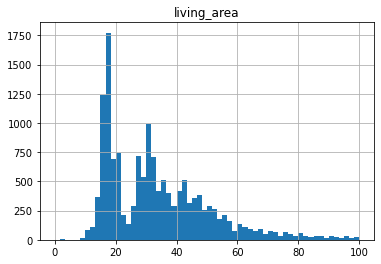

In [18]:
data.hist('living_area', bins=60, range=(0,100))

Отбросим квартиры с жилой площадью менее 10 кв.м. и более 250 кв.м

In [19]:
data.drop(index=data.query('living_area < 10').index,inplace=True)
data.drop(index=data.query('living_area > 250').index,inplace=True)

Столбец floor - этаж. Здесь нет нулевых значений или слишком больших.

Стоблец kitchen_area - площадь кухни в кв.м. 



In [20]:
print('Уникальные значения:', data['kitchen_area'].unique().shape[0])

Уникальные значения: 891


890 вриантов "глазом" не высмотреть. Посмотрим гисторгамму:

array([[<AxesSubplot:title={'center':'kitchen_area'}>]], dtype=object)

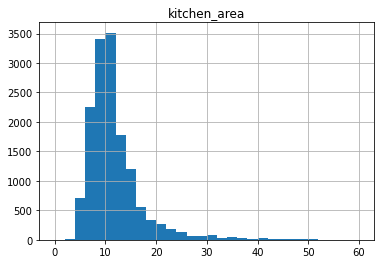

In [21]:
data.hist('kitchen_area', bins=30, range=(0,60))

Удаляем данные менее 5 кв.м и более 50 кв.м

In [22]:
data.drop(index=data.query('kitchen_area < 5').index,inplace=True)
data.drop(index=data.query('kitchen_area > 50').index,inplace=True)

Столбец balcony - количество балконов, всё выглядит хорошо.

Столбцы locality_name, city_centers_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest тоже выглядят достоверными.

Столбец airports_nearest - расстояние до ближайшего аэропорта в метрах. 


In [23]:
print('Неправдоподобно близко к аэропорту:',data.query('airports_nearest < 1000')['airports_nearest'].count())

Неправдоподобно близко к аэропорту: 1


In [24]:
data.drop(index=data.query('airports_nearest < 1000').index,inplace=True)

Столбец days_exposition - сколько дней было размещено объявление. Нулевых значений нет. Объявления, которые висели дольше 2-х лет отбросим.

In [25]:
data.drop(index=data.query('days_exposition > 365*2').index,inplace=True)

Итак, на начальном этапе нашего исследования мы:

- изучили общую информацию о полученном датафрейме.

- построили общую гистограмму для всех числовых столбцов таблицы. 

- нашли и изучили пропущенные значения в столбцах: 

-- переименовали название столбца cityCenters_nearest; 
-- определили, в каких столбцах есть пропуски; 
-- заполнили пропущенные значения там, где это возможно и описали обоснование внесенных или не внесенных наших изменений;
-- рассмотрели типы данных в каждом столбце, внесли изменения в выбранные и обосновали причины изменения типов данных;
-- изучили уникальные значения в столбце с названиями и устранили неявные дубликаты;
-- нашли и устранили редкие и выбивающиеся значения, такие как: аномально маленькая или завышенная стоимость жилья, "опечатки" в высоте потолков квартир, жилую площадь менее 10кв.м. и более 250, кухни с площадью менее 5 кв.м. и более 50кв.м, выявили недвижимость, находящуюся на территории аэропорта и исключили ее из исследования, отбросили объявления со сроком более 2-х лет продажи.


### Посчитайте и добавьте в таблицу новые столбцы

In [26]:
# цена одного квадаратного метра
data['cost_one'] = data['last_price'] / data['total_area']

In [27]:
# день недели публикации объявления (0-понедельник, 1-вторник и так далее), месяца и года
data['weekday'] = data['first_day_exposition'].dt.weekday
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №2__

Этот метод нужен для визуализации динамики по неделям, месяцам или годам (смотря какой метод выберешь)
    
Код выглядит так:
    
        df['first_day_exposition'].dt.date #приводим к временному формату
        df['first_day_exposition'].astype('datetime64[M]') 
    
Если года разные, то в новой колонке месяца у тебя отобразится первый день месяца ('2019-05-01')
</div>

In [28]:
# тип этажа квартиры (значения - "первый", "последний", "другой")
def floor_group(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'
data['floor_type'] = data.apply(floor_group, axis=1)


In [29]:
# раcстояние до центра города в киломентрах (переведите м в км и округлите до целых значение)
data['center_km'] = data['city_centers_nearest'] / 1000
data['center_km'] = data['center_km'].fillna(value=0).astype(int)

### Проведите исследовательский анализ данных

In [30]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,cost_one,weekday,month,year,center_km
count,16049.000000,1.604900e+04,16049.000000,16049.000000,7185.000000,15967.000000,14568.000000,16049.000000,14232.000000,16049.000000,...,16049.000000,5672.000000,16049.000000,6518.000000,14004.000000,16049.000000,16049.000000,16049.000000,16049.000000,16049.000000
mean,9.786404,6.913850e+06,63.184240,2.073525,2.896095,11.529154,35.581374,6.326438,11.416196,0.575737,...,0.494984,495.473025,0.642221,506.594047,152.059983,103171.972763,2.588199,6.425136,2017.345380,9.901178
std,5.777389,6.916160e+06,35.311365,1.103539,0.295164,7.112543,22.262295,5.227506,5.551800,0.966287,...,0.771657,357.677850,0.924278,277.223556,156.662532,46077.079688,1.784037,3.482207,0.984696,9.037039
min,0.000000,4.300000e+05,13.000000,0.000000,2.650000,1.000000,10.000000,1.000000,5.000000,0.000000,...,0.000000,1.000000,0.000000,13.000000,2.000000,7962.962963,0.000000,1.000000,2014.000000,0.000000
25%,5.000000,3.600000e+06,40.800000,1.000000,2.700000,5.000000,18.700000,3.000000,8.000000,0.000000,...,0.000000,283.000000,0.000000,281.000000,44.000000,79470.198675,1.000000,3.000000,2017.000000,2.000000
50%,9.000000,5.000000e+06,54.800000,2.000000,2.800000,9.000000,31.000000,5.000000,10.000000,0.000000,...,0.000000,448.000000,0.000000,485.000000,90.000000,97994.987469,3.000000,6.000000,2017.000000,10.000000
75%,14.000000,7.700000e+06,74.400000,3.000000,3.000000,17.000000,44.000000,9.000000,13.000000,1.000000,...,1.000000,616.250000,1.000000,712.000000,208.250000,119359.534207,4.000000,10.000000,2018.000000,14.000000
max,50.000000,9.900000e+07,494.100000,14.000000,8.000000,60.000000,250.000000,33.000000,50.000000,5.000000,...,3.000000,3190.000000,3.000000,1341.000000,729.000000,848484.848485,6.000000,12.000000,2019.000000,60.000000


Квартиры с наибольшим размером общей площади: 9826     494.10
6621     488.00
6221     470.30
3676     441.98
22131    422.20
Name: total_area, dtype: float64


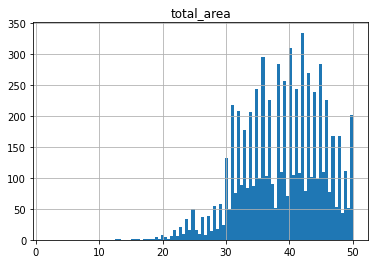

In [31]:
data.hist('total_area', bins=100, range=(2,50))
print("Квартиры с наибольшим размером общей площади:", data['total_area'].sort_values(ascending=False).head())

Квартиры с наибольшим размером жилой площади: 15701    250.0
1494     250.0
6221     248.7
15607    248.5
2580     230.0
Name: living_area, dtype: float64


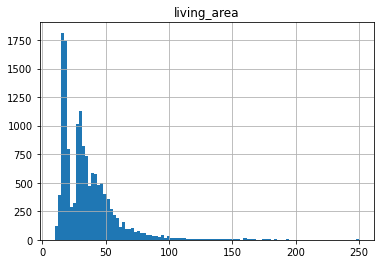

In [32]:
data.hist('living_area', bins=100)
print('Квартиры с наибольшим размером жилой площади:', data['living_area'].sort_values(ascending=False).head())

Квартиры с наибольшим размером кухни: 5042     50.0
656      50.0
511      50.0
19267    50.0
2356     50.0
6621     50.0
10001    50.0
5135     50.0
51       50.0
21331    49.4
Name: kitchen_area, dtype: float64


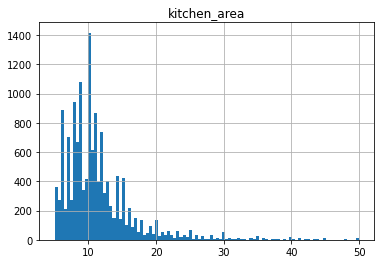

In [33]:
data.hist('kitchen_area', bins=100)
print('Квартиры с наибольшим размером кухни:', data['kitchen_area'].sort_values(ascending=False).head(10))

Квартиры с самой дорогой стоимостью 6621     99000000
5631     99000000
16590    98000000
155      96000000
11329    95000000
Name: last_price, dtype: int64


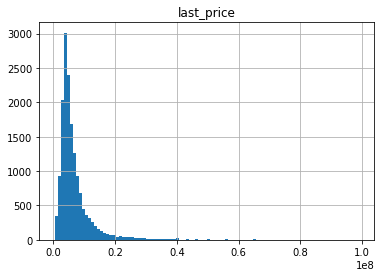

In [34]:
data.hist('last_price', bins=100)
print("Квартиры с самой дорогой стоимостью", data['last_price'].sort_values(ascending=False).head())

Квартиры с большим количеством комнат 20829    14
866      14
648      11
18891    10
4149     10
Name: rooms, dtype: int64


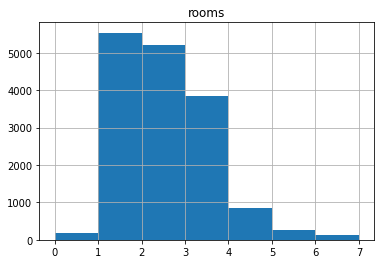

In [35]:
data.hist('rooms', bins=7, range=(0,7))
print("Квартиры с большим количеством комнат", data['rooms'].sort_values(ascending=False).head())

Квартиры с самыми высокими потолками: 3474     8.0
15743    8.0
17442    8.0
21227    5.8
1388     5.6
Name: ceiling_height, dtype: float64


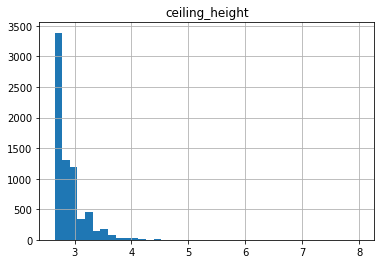

In [36]:
data.hist('ceiling_height', bins=40)
print("Квартиры с самыми высокими потолками:", data['ceiling_height'].sort_values(ascending=False).head())

array([[<AxesSubplot:title={'center':'floor'}>]], dtype=object)

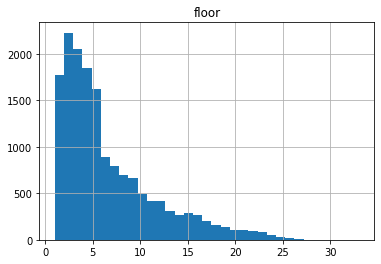

In [37]:
data.hist('floor', bins=data['floor'].max())

<AxesSubplot:xlabel='floor_type', ylabel='count'>

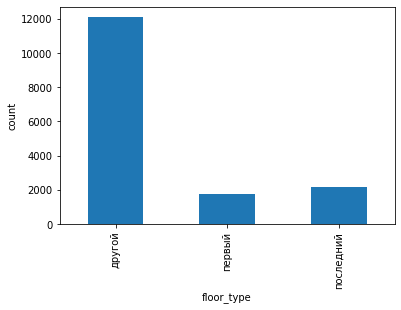

In [38]:
data.groupby(by='floor_type')['floor_type'].count().plot(kind='bar', ylabel = 'count')

array([[<AxesSubplot:title={'center':'floors_total'}>]], dtype=object)

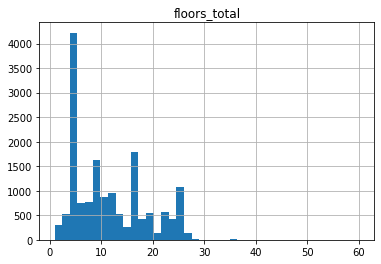

In [39]:
data.hist('floors_total', bins=40)

array([[<AxesSubplot:title={'center':'city_centers_nearest'}>]],
      dtype=object)

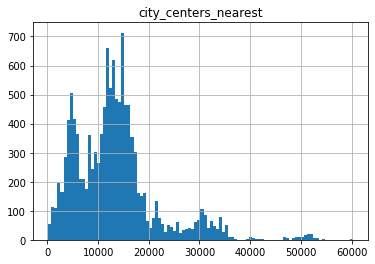

In [40]:
data.hist('city_centers_nearest', bins=100)

array([[<AxesSubplot:title={'center':'airports_nearest'}>]], dtype=object)

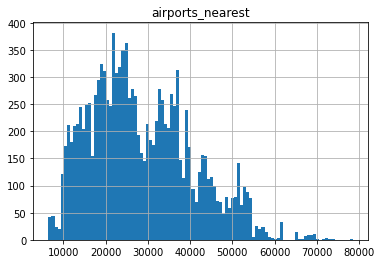

In [41]:
data.hist('airports_nearest', bins=100)

array([[<AxesSubplot:title={'center':'parks_nearest'}>]], dtype=object)

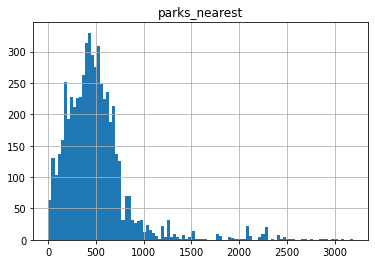

In [42]:
data.hist('parks_nearest', bins=100)

array([[<AxesSubplot:title={'center':'weekday'}>]], dtype=object)

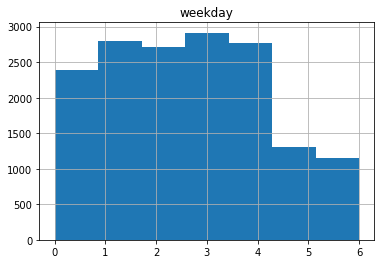

In [43]:
data.hist('weekday', bins=7)

array([[<AxesSubplot:title={'center':'month'}>]], dtype=object)

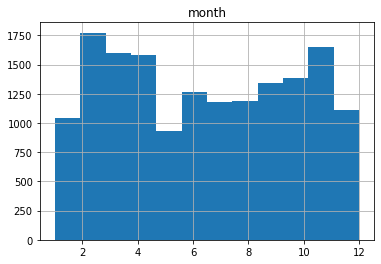

In [44]:
data.hist('month', bins=12)

In [45]:
  #data[['total_area', 'living_area',  'kitchen_area', 'last_price', 'ceiling_height', 'rooms', 'floors_total', 'floor_type', 'city_centers_nearest', 'airports_nearest', 'parks_nearest', 'weekday', 'month']].apply (['count', 'min', 'max'])
  data[['total_area', 'living_area',  'kitchen_area', 'last_price', 'ceiling_height', 'rooms', 'floors_total', 'city_centers_nearest', 'airports_nearest', 'parks_nearest', 'weekday', 'month']].describe() 

,total_area,living_area,kitchen_area,last_price,ceiling_height,rooms,floors_total,city_centers_nearest,airports_nearest,parks_nearest,weekday,month
count,16049.000000,14568.000000,14232.000000,1.604900e+04,7185.000000,16049.000000,15967.000000,12415.000000,12399.000000,5672.000000,16049.000000,16049.000000
mean,63.184240,35.581374,11.416196,6.913850e+06,2.896095,2.073525,11.529154,13294.301329,28500.052746,495.473025,2.588199,6.425136
std,35.311365,22.262295,5.551800,6.916160e+06,0.295164,1.103539,7.112543,8273.322985,12119.503072,357.677850,1.784037,3.482207
min,13.000000,10.000000,5.000000,4.300000e+05,2.650000,0.000000,1.000000,181.000000,6450.000000,1.000000,0.000000,1.000000
25%,40.800000,18.700000,8.000000,3.600000e+06,2.700000,1.000000,5.000000,7625.000000,19015.500000,283.000000,1.000000,3.000000
50%,54.800000,31.000000,10.000000,5.000000e+06,2.800000,2.000000,9.000000,12548.000000,26313.000000,448.000000,3.000000,6.000000
75%,74.400000,44.000000,13.000000,7.700000e+06,3.000000,3.000000,17.000000,15987.000000,36623.500000,616.250000,4.000000,10.000000
max,494.100000,250.000000,50.000000,9.900000e+07,8.000000,14.000000,60.000000,60223.000000,78527.000000,3190.000000,6.000000,12.000000


Основное количество продаваемых квартир - с общей площадью от 40 до 74 кв.м. Максимальная общая площадь - 494 кв.м. 

При этом основная доля квартир с жилой площадью от 18 кв. м. до 44, при размере кухонь от 8 кв.м. до 13 кв.м.

Именно с такой квадратурой больше всего продано недвижимости с последней ценой в рамках 3.6 млн до 13 млн. Максимальная стоимость жилья составила 99 млн. 

Остновное количество комнат: 1-2. Показанный нам минимум - 0 комнат, предположительно относится к квартирам типа "студия", поэтому не вызывает сомнений в своей правильности.

Выстота потолков, в общей массе проданных квартир, так же соответсвует всем стандартам застройки от 2.7 до 3 м. Максимально мы видим 8 м, что вполне сообветсвует двухуровневым квартирам.

Как и следовало ожидать, первые и последние этажи не составляют массовую долю продаж. В основном продавались средние этажи домов. 

Большинство квартир продавалось на расстоянии отт 7625 до 15987 м от центра города. А растояние от аэропорта составило от 19015 до 36623 м. Парки везде есть, что очень приятно.

Логично так же, что все даты продаж проходили в рабочие дни, как мы и видим по столбцу weekday, особенно продуктивно-продаваемый день - четверг. А вот по месяцам - зимние месяцы прям затишье продаж. Пик приходится на июль. 





count    14004.000000
mean       152.059983
std        156.662532
min          2.000000
25%         44.000000
50%         90.000000
75%        208.250000
max        729.000000
Name: days_exposition, dtype: float64


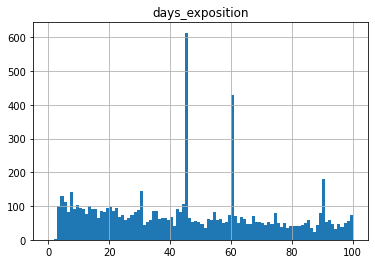

In [46]:
data.hist('days_exposition', bins=100, range = (0,100));
print(data['days_exposition'].describe())

Самой быстрой продажей была недвижимость проданная за 2 дня. А вот самая долгая - более 2 лет.

В среднем квартиры продавались от 44 дней до 208.

Среднее время продажи квартиры в днях составило 152 дня.

Медианное время продажи квартиры в днях: 90.


Зависимость цены от общей площади недвижимости:

0.7625869017649516


<AxesSubplot:xlabel='last_price', ylabel='total_area'>

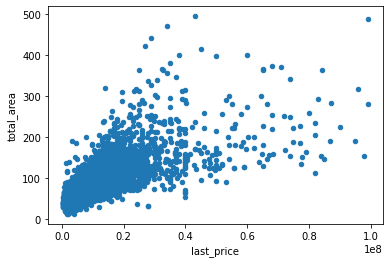

In [48]:
print(data['last_price'].corr(data['total_area']))
data.plot(x='last_price', y='total_area', kind='scatter')

Корреляция стоимости квартиры от общей площади самая высокая = 0.7626. Это самая большая зависимость стоимости.

Зависимость цены от жилой площади недвижимости:


0.6859017814135909


<AxesSubplot:xlabel='last_price', ylabel='living_area'>

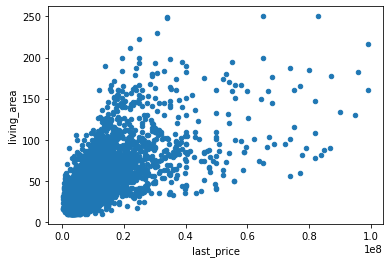

In [49]:
print(data['last_price'].corr(data['living_area']))
data.plot(x='last_price', y='living_area', kind='scatter')

Корреляция стоимости квартиры от жилой площади чуть ниже и составляет 0.6859.

Зависимость цены от площади кухни:

0.5465376681119473


<AxesSubplot:xlabel='last_price', ylabel='kitchen_area'>

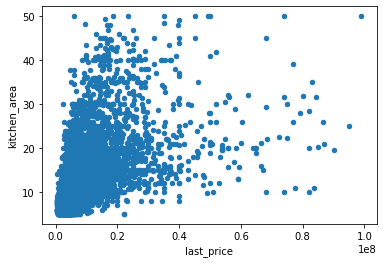

In [50]:
print(data['last_price'].corr(data['kitchen_area']))
data.plot(x='last_price', y='kitchen_area', kind='scatter')

Корреляция стоимости квартиры от площади кухни еще чуть ниже и составляет 0.5465.

Зависимость цены от количества комнат:

0.49834138173482717


<AxesSubplot:xlabel='last_price', ylabel='rooms'>

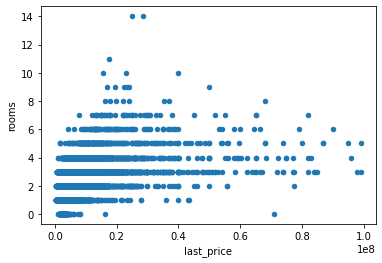

In [51]:
print(data['last_price'].corr(data['rooms']))
data.plot(x='last_price', y='rooms', kind='scatter')

Корреляция стоимости квартиры от количества комнат еще ниже и составляет 0.4983.

<AxesSubplot:xlabel='floor_type'>

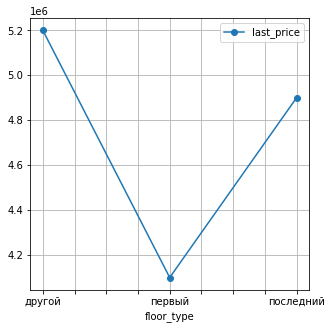

In [56]:
data.pivot_table(index='floor_type', values='last_price', aggfunc='median').plot(grid=True, style='o-', figsize=(5, 5))


Самая низкая цена у квартир на 1-м этаже, даже последний стоит выше. 

Зависимость цены от даты размещения (день недели, мясц, год):

<AxesSubplot:xlabel='year'>

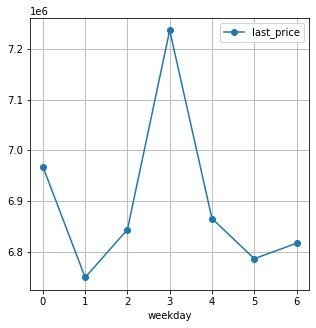

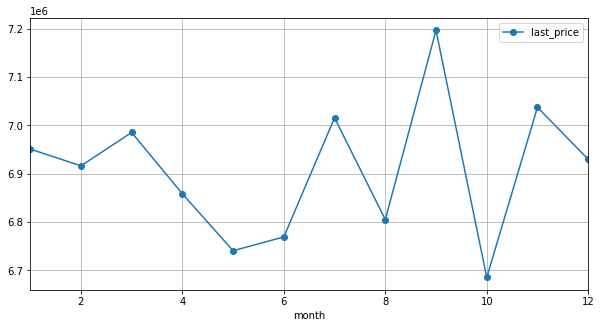

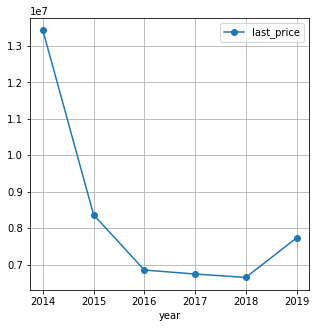

In [57]:
data.pivot_table(index='weekday', values='last_price').plot(grid=True, style='o-', figsize=(5, 5))

data.pivot_table(index='month', values='last_price').plot(grid=True, style='o-', xlim=(1,12), figsize=(10, 5))

data.pivot_table(index='year', values='last_price').plot(grid=True, style='o-', figsize=(5, 5))


Зависимость стоимости квартиры от даты размещения тоже прослеживается. Самым размещаяемым днем недели оказался четверг. А соглансо графику корреляции по месяцам, самый пик желающих продать квартиру приходился на ноябрь. По года мы же видим уверенный спат стоимости до 2017 года, а в 2018 начинается плавный рост.

<AxesSubplot:xlabel='year'>

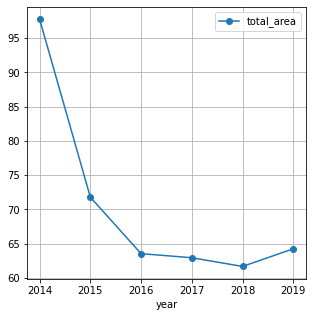

In [58]:
data.pivot_table(index='year', values='total_area').plot(grid=True, style='o-', figsize=(5, 5))

Графики цены и площади продаваемых квартир почти одинаковые. Все взаимосвязано.

In [59]:
city_ten = data['locality_name'].value_counts().head(10)
city_sm_price = data.query('locality_name in (@city_ten.index)').pivot_table(values='cost_one', index='locality_name')
city_sm_price = city_sm_price.astype(int)
city_sm_price.sort_values('cost_one', ascending=False)

,cost_one
locality_name,
Санкт-Петербург,117967
Пушкин,105250
деревня Кудрово,92734
поселок Парголово,88990
поселок Мурино,85728
поселок Шушары,78524
Колпино,75553
Всеволожск,70791
Гатчина,69373


Самыми активно продающими квартиры городами оказались: Санкт-Петербург, Пушкин, деревня Кудрово, оселок Парголово, поселок Мурино, поселок Шушары, Колпино, Всеволожск, Гатчина, Выборг.При этом количество объявлений у лидера, города Сантк-Петербурга, вдвое выше, что м у большинства городов и поселков, вошедших в топ 10.


In [60]:
data.groupby('locality_name').agg({'balcony':'count', 'last_price':'median'}) \
    .sort_values(by = 'balcony', ascending = False) \
    .head(10)

,balcony,last_price
locality_name,,
Санкт-Петербург,10924,6200000.0
поселок Мурино,486,3324020.5
поселок Шушары,319,4000000.0
деревня Кудрово,273,3800000.0
Всеволожск,267,3550000.0
поселок Парголово,247,4100000.0
Пушкин,228,5975000.0
Гатчина,193,3200000.0
Колпино,188,3650000.0


<AxesSubplot:title={'center':'Заголовок'}, xlabel='center_km'>

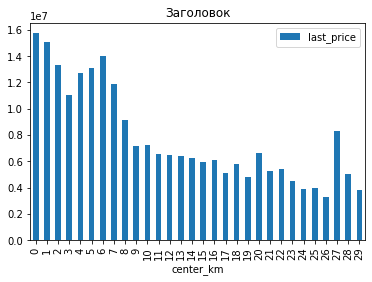

In [61]:
#print(data['locality_name'].head())
data[data['locality_name']=='Санкт-Петербург'].pivot_table(index= 'center_km', values='last_price', aggfunc='mean')\
    .plot(kind='bar', title = 'Заголовок')



Средняя площадь: 68
Средняя площадь в центре: 91


<AxesSubplot:>

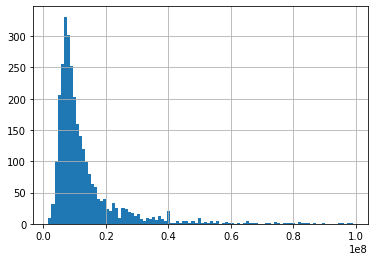

In [62]:
spb_center = data.query('(locality_name == "Санкт-Петербург") & (center_km <= 6.957)')
print('Средняя площадь:', round(data.query('locality_name == "Санкт-Петербург"')['total_area'].mean()))
print('Средняя площадь в центре:', round(spb_center['total_area'].mean()))
spb_center['last_price'].hist(bins=100)


    В городе Санкт-Петербург, как в Северной столице, больше всего предложений по продаже квартир. Средняя площадь продаваемых квартир 68 кв.м., а вот в центре города = 91 кв.м. С большим отрывом лидирует недвижимость до 1км от центра.Видим более низкие цены на недвижимость на расстоянии от 1 км. до 7 км. включительно. Далее цена спадает на расстоянии от 8 км. до 27 км. Видим пик на 27км, возможно это недвижимость в загородном "закрытом" районе. 

### Общий вывод

Итак, какие результаты исследования мы получили:

- всегда нужно проверять таблицы на предмет ошибок при вводе данных или их пропуска.

- основное количество продаваемых квартир - с общей площадью от 40 до 74 кв.м. Максимальная общая площадь - 494 кв.м.
При этом основная доля квартир с жилой площадью от 18 кв. м. до 44, при размере кухонь от 8 кв.м. до 13 кв.м. 
Именно с такой квадратурой больше всего продано недвижимости с последней ценой в рамках 3.6 млн до 13 млн. Максимальная стоимость жилья составила 99 млн.

- основное количество комнат: 1-2. Показанный нам минимум - 0 комнат, предположительно относится к квартирам типа "студия", поэтому не вызывает сомнений в своей правильности.

- выстота потолков, в общей массе проданных квартир, так же соответсвует всем стандартам застройки от 2.7 до 3 м. Максимально мы видим 8 м, что вполне сообветсвует двухуровневым квартирам.

- как и следовало ожидать, первые и последние этажи не составляют массовую долю продаж. В основном продавались средние этажи домов.

- большинство квартир продавалось на расстоянии отт 7625 до 15987 м от центра города. А растояние от аэропорта составило от 19015 до 36623 м. Парки везде есть, что очень приятно.

- логично так же, что все даты продаж проходили в рабочие дни, как мы и видим по столбцу weekday, особенно продуктивно-продаваемый день - четверг. А вот по месяцам - зимние месяцы прям затишье продаж. Пик приходится на июль.

- общая (полная) стоимость объекта завсисит от от всех основных параметров: общей и жилой площадей, размера кухни, количества комнат. Больше всего от размера общей площади и относительно меньше от количества комнат.

- самая низкая цена у квартир на 1-м этаже, даже последний стоит дороже.

- зависимость стоимости квартиры от даты размещения тоже прослеживается. Самым размещаемым днем недели оказался четверг. А согласно графику корреляции по месяцам, самый прик желающих продать квартиру приходился на ноябрь. 

- самыми активно продающими квартиры городами оказались: Санкт-Петербург, Пушкин, деревня Кудрово, оселок Парголово, поселок Мурино, поселок Шушары, Колпино, Всеволожск, Гатчина, Выборг.При этом количество объявлений у лидера, города Сантк-Петербурга, вдвое выше, что м у большинства городов и поселков, вошедших в топ 10.

-  в городе Санкт-Петербург, как в Северной столице, больше всего предложений по продаже квартир. Средняя площадь продаваемых квартир 68 кв.м., а вот в центре города = 91 кв.м. С большим отрывом лидирует недвижимость до 1км от центра.Видим более низкие цены на недвижимость на расстоянии от 1 км. до 7 км. включительно. Далее цена спадает на расстоянии от 8 км. до 27 км. Видим пик на 27км, возможно это недвижимость в загородном "закрытом" районе.


**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод `info()`, гистограммы и т.д.)
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения там, где это возможно
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  устранены неявные дубликаты в названиях населённых пунктов
- [x]  устранены редкие и выбивающиеся значения (аномалии) во всех столбцах
- [x]  посчитано и добавлено в таблицу: цена одного квадратного метра
- [x]  посчитано и добавлено в таблицу: день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
- [x]  посчитано и добавлено в таблицу: месяц публикации объявления
- [x]  посчитано и добавлено в таблицу: год публикации объявления
- [x]  посчитано и добавлено в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)
- [x]  посчитано и добавлено в таблицу: расстояние в км до центра города
- [x]  изучены и описаны следующие параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.
    - Постройте гистограмму.
    - Посчитайте среднее и медиану.
    - В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"
- [x]  выполнено задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."
        - общей площади;
        - жилой площади;
        - площади кухни;
        - количество комнат;
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        - даты размещения (день недели, месяц, год);
- [x]  выполнено задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`."
- [x]  выполнено задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."
- [x]  в каждом этапе есть промежуточные выводы
- [x]  есть общий вывод